<a href="https://colab.research.google.com/github/meganhmoore/LingoQuartet/blob/main/notebooks/lisette_title_BERT_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tune BERT Model -- title version
Code in this notebook is used to fine tune BERT model with titles. It is very similar to the text version except that it is missing logic to calculate the VADER sentiment as the average sentences across sentences. Files were also seperated to run both at the same time.

Ultimately did not use model trained on titles because the text had more variation in sentiment.

In [ ]:
!pip install vaderSentiment
!pip install transformers==4.23.1
!pip install torch
!pip install functools
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.1
    Uninstalling transformers-4.38.1:
      Successfully uninstalled transformers-4.38.1
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for functools
  Running setup.py clean for functools
Failed to build functools
ERROR: Could not build wh

In [ ]:
from google.colab import drive

import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import torch
from torch import nn
import torch
import torch.nn as nn
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import AutoTokenizer, TrainingArguments, Trainer, DistilBertConfig, DistilBertForSequenceClassification, BertConfig
from sklearn.metrics import f1_score, precision_recall_fscore_support, accuracy_score
from functools import partial
import accelerate

In [ ]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


# Load Data

In [ ]:
# Mount Google Drive
drive.mount('/content/gdrive')

# Define the file path
path = "/content/gdrive/MyDrive/Advanced ML/2020articles_cleaned_forsentiment.csv"

# Load data
full_df = pd.read_csv(path)

Mounted at /content/gdrive


In [ ]:
full_df.columns

Index(['Unnamed: 0', 'uuid', 'source', 'year', 'article_text', 'title',
       'full_article_text', 'title_text'],
      dtype='object')

In [ ]:
df = full_df.sample(n=20000)
df = df.loc[:,['uuid', 'title']]

In [ ]:
len(df)

20000

# Sentiment Analysis

### Make labels using Vader

In [ ]:
analyzer = SentimentIntensityAnalyzer()
sentiment_score = analyzer.polarity_scores('crisis averted as senate passes spending bill')
sentiment_score

{'neg': 0.519, 'neu': 0.481, 'pos': 0.0, 'compound': -0.6597}

In [ ]:
analyzer = SentimentIntensityAnalyzer()
sentiment_score = analyzer.polarity_scores('house democrats admit to not being happy about changes made to bill')
sentiment_score

{'neg': 0.203, 'neu': 0.676, 'pos': 0.122, 'compound': -0.2955}

Actual headlines

In [ ]:
analyzer = SentimentIntensityAnalyzer()
sentiment_score = analyzer.polarity_scores('off the rails: moderators struggle as 10th democratic debate turns into absolute shouting match')
sentiment_score

{'neg': 0.15, 'neu': 0.85, 'pos': 0.0, 'compound': -0.3182}

In [ ]:
analyzer = SentimentIntensityAnalyzer()
sentiment_score = analyzer.polarity_scores('netanyahu expresses deep shock over elevator drowning after record rainfall')
sentiment_score

{'neg': 0.224, 'neu': 0.776, 'pos': 0.0, 'compound': -0.3818}

In [ ]:
def classify_sentiment(title):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_score = analyzer.polarity_scores(title)
    if sentiment_score['compound'] >= 0.5:
      return 5
    elif sentiment_score['compound'] >= 0.3:
      return 4
    elif sentiment_score['compound'] <= -0.5:
      return 2
    elif sentiment_score['compound'] <= -0.3:
      return 1
    else:
      return 3

In [ ]:
df['sentiment_score'] = df['title'].apply(classify_sentiment)
df = df[df['sentiment_score'].notna()]

### Make Dataloader (code from Hugging Face)
*   Split into train and test



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['sentiment_score'], test_size=0.2)

In [ ]:
X_train[:50].to_list()

['SI Board Facing Significant Changes After Blue Lives Matter Ad',
 'PICS: Antifa, Black Lives Matter Flood London Despite Lockdown, Police Do Little',
 'Tucker Carlson Blames Political Power on Surging Crime — No Hope Until Its Taken Seriously',
 'Joe Biden Names LGBTQ Legal Advocate, Planned Parenthood Exec to Administration',
 'Heilemann: Trump Supporters Ready to Take up Arms, Press Tactics That Lead to Civil War',
 '          Chuck Schumer calls for delay on Amy Coney Barrett hearings        ',
 'Trump tells Arizona rally Bidens lucky Barr hasnt locked him up',
 'White House Begins Temperature Checks for Press',
 'Disqualified: Tom Cotton Blasts Bidens Homeland Security Pick, Who Exerted Improper Influence In Visa Program',
 'Facing Pressure, Trump Relents On Starting Biden Transition',
 'Twin Cities Riots Heighten Unpredictability of 2020 Election in Battleground State of Minnesota',
 'Cotton: This Is Going to Be a Very, Very Closely Divided Congress',
 'Man Gets 20 Years in Pris

In [ ]:
# Load the DistilBERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# The dataset class
class TheDataset(torch.utils.data.Dataset):

    def __init__(self, texts, sentiments, tokenizer):
        self.texts = texts
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.max_len = tokenizer.model_max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        sentiments = self.sentiments[index]

        encoded_text = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
            padding="max_length",
            truncation=True
        )

        return {
            'input_ids': encoded_text['input_ids'][0],
            'attention_mask': encoded_text['attention_mask'][0],
            'labels': torch.tensor(sentiments, dtype=torch.long) - 1  # Adjust labels to start from 0
        }

# Prepare the Train/Validation sets
train_set_dataset = TheDataset(
    texts=X_train.tolist(),
    sentiments=y_train.tolist(),
    tokenizer=tokenizer,
)

valid_set_dataset = TheDataset(
    texts=X_test.tolist(),
    sentiments=y_test.tolist(),
    tokenizer=tokenizer,
)

# Load the DistilBERT model
config = DistilBertConfig.from_pretrained("distilbert-base-uncased")
config.num_labels = 5
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

# Initialize the bias and weight for the classifier layer
model.classifier.bias.data.fill_(0)
model.classifier.weight.data.normal_(mean=0.0, std=0.02)

# The function to get the accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')  # Change average to 'weighted'
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define the training parameters
training_args = TrainingArguments(
    output_dir="./sentiment-analysis",
    num_train_epochs=3,
    per_device_train_batch_size=16,  # Change back to 64 if resources allow
    per_device_eval_batch_size=64,
    warmup_steps=30,
    weight_decay=0.01,
    save_strategy="epoch",
    evaluation_strategy="steps"
)

# Define trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set_dataset,
    eval_dataset=valid_set_dataset,
    compute_metrics=compute_metrics
)

# Start pre-training!
trainer.train()


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.23.1",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.965300,0.694121,0.738000,0.734882,0.733638,0.738000
1000,0.660300,0.558255,0.794000,0.784106,0.788634,0.794000
1500,0.431700,0.523832,0.817000,0.817472,0.822690,0.817000
2000,0.393900,0.435232,0.842500,0.843947,0.846790,0.842500
2500,0.224000,0.513907,0.837250,0.836957,0.838295,0.837250
3000,0.211300,0.489216,0.851250,0.852294,0.854224,0.851250


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 64
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 64
Saving model checkpoint to ./sentiment-analysis/checkpoint-1000
Configuration saved in ./sentiment-analysis/checkpoint-1000/config.json
Model weights saved in ./sentiment-analysis/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 64
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 64
Saving model checkpoint to ./sentiment-analysis/checkpoint-2000
Configuration saved in ./sentiment-analysis/checkpoint-2000/config.json
Model weights saved in ./sentiment-analysis/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 64
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 64
Saving model checkpoint to ./sentiment-analysis/checkpoint-3000
Configuration saved in ./sentiment-analysis/checkpoint-3000/config.json
Model weig

TrainOutput(global_step=3000, training_loss=0.48109473673502606, metrics={'train_runtime': 880.975, 'train_samples_per_second': 54.485, 'train_steps_per_second': 3.405, 'total_flos': 6358775316480000.0, 'train_loss': 0.48109473673502606, 'epoch': 3.0})

In [ ]:
# Evaluate the model on the validation set
results = trainer.evaluate()

# Print the evaluation results
print("Evaluation Results:", results)

***** Running Evaluation *****
  Num examples = 4000
  Batch size = 64


Evaluation Results: {'eval_loss': 0.5177571177482605, 'eval_accuracy': 0.84175, 'eval_f1': 0.8432104905137875, 'eval_precision': 0.8452559515165978, 'eval_recall': 0.84175, 'eval_runtime': 20.0752, 'eval_samples_per_second': 199.25, 'eval_steps_per_second': 3.138, 'epoch': 3.0}


In [ ]:
# Save a fine-tuned model
model_save_directory = "/content/gdrive/MyDrive/model_save_directory/title_sentiment_bert_20000_fullyprocessed"
trainer.save_model(model_save_directory)

Saving model checkpoint to /content/gdrive/MyDrive/model_save_directory/title_sentiment_bert_20000_fullyprocessed
Configuration saved in /content/gdrive/MyDrive/model_save_directory/title_sentiment_bert_20000_fullyprocessed/config.json
Model weights saved in /content/gdrive/MyDrive/model_save_directory/title_sentiment_bert_20000_fullyprocessed/pytorch_model.bin


In [ ]:
# New text for prediction
new_text = 'off the rails: moderators struggle as 10th democratic debate turns into absolute shouting match'

# Tokenize the new text
inputs = tokenizer(new_text, return_tensors='pt')

# Move input tensors to the same device as the model
inputs = {key: value.to(model.device) for key, value in inputs.items()}

# Forward pass through the trained model
with torch.no_grad():
    outputs = model(**inputs)

# Get predicted probabilities and labels
probs = torch.softmax(outputs.logits, dim=-1)
predicted_class = torch.argmax(probs)

# Convert the predicted class index to a human-readable label
label_map = {0: 'Negative', 1: 'Somewhat Negative', 2: 'Neutral', 3: 'Somewhat Positive', 4: 'Positive'}
predicted_label = label_map[predicted_class.item()]

print(f"Predicted Label: {predicted_label}")


Predicted Label: Negative


## Load Saved Model

In [ ]:
# To reload a saved model
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model_save_directory = "/content/gdrive/MyDrive/model_save_directory/title_sentiment_bert_20000_fullyprocessed"
model = DistilBertForSequenceClassification.from_pretrained(model_save_directory)
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
full_df['vader_sentiment_score'] = full_df['title'].apply(classify_sentiment)
full_df = full_df[full_df['vader_sentiment_score'].notna()]

In [ ]:
def bert_sentiment(text, tokenizer, model):
  """
   Precits sentiment of text using fine tuned BERT model.
  """
  # Tokenize the new text
  inputs = tokenizer(text, return_tensors='pt')

  # Move input tensors to the same device as the model
  inputs = {key: value.to(model.device) for key, value in inputs.items()}

  # Forward pass through the trained model
  with torch.no_grad():
      outputs = model(**inputs)

  # Get predicted probabilities and labels
  probs = torch.softmax(outputs.logits, dim=-1)
  predicted_class = torch.argmax(probs)

  return predicted_class.item() + 1 # add one to standardize to 5 point scale

In [ ]:
full_df['bert_sentiment_score'] = full_df['title'].apply(lambda x: bert_sentiment(x, tokenizer, model))

In [ ]:
# Get counts for each unique value in the 'Category' column
value_counts = full_df['vader_sentiment_score'].value_counts()

# Create a new DataFrame to represent the table
table_df = pd.DataFrame({'VADER Sentiment Score': value_counts.index, 'Count': value_counts.values})
table_df['Percentage'] = (table_df['Count']/len(df)).round(4)

# Display the resulting table
table_df

,VADER Sentiment Score,Count,Percentage
0,3,19126,0.9563
1,2,6176,0.3088
2,1,4406,0.2203
3,4,3834,0.1917
4,5,3493,0.1746


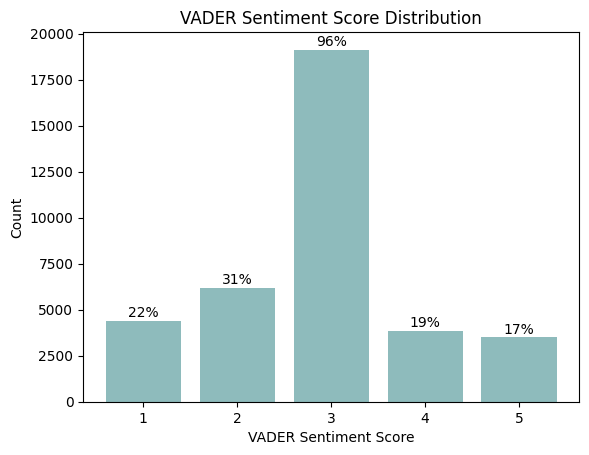

In [ ]:
# Create a bar chart
plt.bar(table_df['VADER Sentiment Score'], table_df['Count'], color='cadetblue', alpha=0.7, label='Count')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Count')
plt.title('VADER Sentiment Score Distribution')

# Add percentage labels to each bar
for i, val in enumerate(table_df['Percentage']):
    plt.text(table_df['VADER Sentiment Score'][i], table_df['Count'][i] + 50, f'{val:.0%}', ha='center', va='bottom')

# Show the plot
plt.show()

In [ ]:
# Get counts for each unique value in the 'Category' column
value_counts = full_df['bert_sentiment_score'].value_counts()

# Create a new DataFrame to represent the table
table_df = pd.DataFrame({'BERT Sentiment Score': value_counts.index, 'Count': value_counts.values})
table_df['Percentage'] = (table_df['Count']/len(df)).round(4)

# Display the resulting table
table_df

,BERT Sentiment Score,Count,Percentage
0,3,18947,0.9474
1,2,6122,0.3061
2,1,4563,0.2282
3,4,4019,0.2010
4,5,3384,0.1692


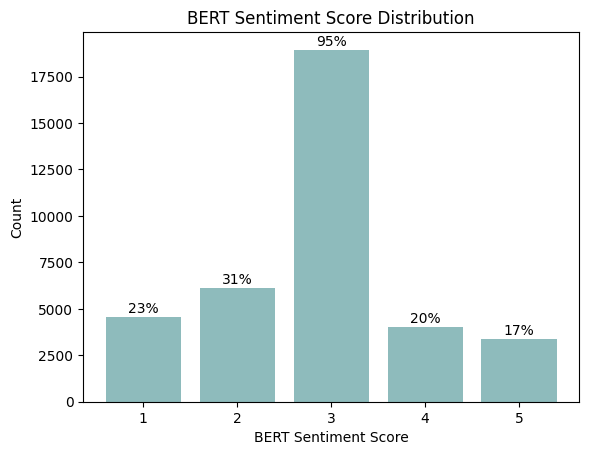

In [ ]:
# Create a bar chart
plt.bar(table_df['BERT Sentiment Score'], table_df['Count'], color='cadetblue', alpha=0.7, label='Count')
plt.xlabel('BERT Sentiment Score')
plt.ylabel('Count')
plt.title('BERT Sentiment Score Distribution')

# Add percentage labels to each bar
for i, val in enumerate(table_df['Percentage']):
    plt.text(table_df['BERT Sentiment Score'][i], table_df['Count'][i] + 50, f'{val:.0%}', ha='center', va='bottom')

# Show the plot
plt.show()

### Analyze Changes

In [ ]:
diff_df = full_df[full_df['vader_sentiment_score'] != full_df['bert_sentiment_score']]
diff_df

,Unnamed: 0,uuid,source,year,article_text,title,full_article_text,title_text,vader_sentiment_score,bert_sentiment_score
21,21,d3da34a8-3da2-11ee-a96e-33dec8f414a2,dailycaller,2020,A British horror parody of Winnie the Pooh was...,New Winnie The Pooh Horror Film Inexplicably Y...,A British horror parody of Winnie the Pooh was...,New Winnie The Pooh Horror Film Inexplicably Y...,2,1
26,26,ebd4fa01-3da2-11ee-a96e-33dec8f414a2,dailycaller,2020,Gun stores are closing at rapid rates after th...,Zero Tolerance: The Biden Admin Is Allegedly S...,Gun stores are closing at rapid rates after th...,Zero Tolerance: The Biden Admin Is Allegedly S...,1,2
31,31,fef56624-3da2-11ee-a96e-33dec8f414a2,dailycaller,2020,A Christian high school issued an apology for ...,Christian High School Apologizes For Racist Bl...,A Christian high school issued an apology for ...,Christian High School Apologizes For Racist Bl...,1,2
58,58,b61e1252-3da3-11ee-a96e-33dec8f414a2,dailycaller,2020,Media personalities and Democratic lawmakers c...,No One Is Above The Law: Media Personalities A...,Media personalities and Democratic lawmakers c...,No One Is Above The Law: Media Personalities A...,3,4
60,60,e0ff5f5c-3da3-11ee-a96e-33dec8f414a2,dailycaller,2020,Rep. Lauren Boebert survived a primary challen...,Boebert Defeats Primary Challenger In Colorado...,Rep. Lauren Boebert survived a primary challen...,Boebert Defeats Primary Challenger In Colorado...,3,1
...,...,...,...,...,...,...,...,...,...,...
36982,36991,0ccbcf20-4136-11ee-a96e-33dec8f414a2,npr,2020,By Avie Schneider ...,Stocks Soar After Strong Retail Sales And Repo...,By Avie Schneider ...,Stocks Soar After Strong Retail Sales And Repo...,5,4
36987,36996,efb2294b-4136-11ee-a96e-33dec8f414a2,npr,2020,Barbara Sprunt ...,Biden Says He's 'Not A Fan' Of Expanding The S...,Barbara Sprunt ...,Biden Says He's 'Not A Fan' Of Expanding The S...,4,3
36992,37001,19e4fbbd-4135-11ee-a96e-33dec8f414a2,npr,2020,Selena Simmons-Duffin ...,Trump Administration Clears The Way For Medica...,Selena Simmons-Duffin ...,Trump Administration Clears The Way For Medica...,3,1
37002,37011,3fc5b63a-4136-11ee-a96e-33dec8f414a2,npr,2020,Debbie Elliott ...,Sessions Fights For His Political Life As Trum...,Debbie Elliott ...,Sessions Fights For His Political Life As Trum...,2,1


In [ ]:
# # Specify the file path where you want to save the Excel file
# diff_file_path = "/content/gdrive/MyDrive/Advanced ML/diff_sentiment_title.csv"

# # Save the DataFrame to Excel
# diff_df.to_csv(diff_file_path, index=False)

In [ ]:
diff_df['change'] =  diff_df['bert_sentiment_score'] - diff_df['vader_sentiment_score']

<ipython-input-80-c89ebb99a361>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['change'] =  diff_df['bert_sentiment_score'] - diff_df['vader_sentiment_score']


-0.07714586624539231

In [ ]:
len(diff_df)

3798

In [ ]:
diff_df['change'].mean()

-0.07714586624539231